In [29]:
#!pip install torch pandas numpy scikit-learn --quiet

In [ ]:
import pandas as pd

# Download MovieLens 100k data
!wget -nc https://files.grouplens.org/datasets/movielens/ml-100k/u.data

# Load ratings
ml_ratings = pd.read_csv('u.data', sep='\t', names=['user', 'item', 'rating', 'timestamp'])
ml_ratings['user'] -= 1
ml_ratings['item'] -= 1
ml_ratings['rating'] = (ml_ratings['rating'] > 0).astype(int)  # Binarize ratings

num_users = ml_ratings['user'].nunique()
num_items = ml_ratings['item'].nunique()

File ‘u.data’ already there; not retrieving.



In [ ]:
# data.py
import numpy as np
import torch
from torch.utils.data import Dataset

class UserItemRatingDataset(Dataset):
    def __init__(self, user_item_pairs, ratings, num_items, num_ng=4, is_training=True):
        self.user_item_pairs = user_item_pairs
        self.ratings = ratings
        self.num_items = num_items
        self.num_ng = num_ng
        self.is_training = is_training
        if is_training:
            self._ng_sample()
        else:
            self.data = [(u, i, r) for (u, i), r in zip(self.user_item_pairs, self.ratings)]
    def _ng_sample(self):
        self.data = []
        user_item_set = set(self.user_item_pairs)
        for idx, ((u, i), r) in enumerate(zip(self.user_item_pairs, self.ratings)):
            self.data.append((u, i, r))
            for _ in range(self.num_ng):
                j = np.random.randint(self.num_items)
                while (u, j) in user_item_set:
                    j = np.random.randint(self.num_items)
                self.data.append((u, j, 0))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        u, i, r = self.data[idx]
        return torch.LongTensor([u]), torch.LongTensor([i]), torch.FloatTensor([r])

class SampleGenerator:
    def __init__(self, ratings):
        # Split train/test (leave one out for test)
        self.ratings = ratings
        self.train_pairs, self.train_ratings, self.test_pairs, self.test_ratings = self._split()
    def _split(self):
        train_pairs, train_ratings = [], []
        test_pairs, test_ratings = [], []
        ratings_group = self.ratings.groupby('user')
        for user, group in ratings_group:
            group = group.sort_values('timestamp')
            test = group.iloc[-1]
            train = group.iloc[:-1]
            for _, row in train.iterrows():
                train_pairs.append((int(row['user']), int(row['item'])))
                train_ratings.append(int(row['rating']))
            test_pairs.append((int(test['user']), int(test['item'])))
            test_ratings.append(int(test['rating']))
        return train_pairs, train_ratings, test_pairs, test_ratings

In [ ]:
%%writefile gmf.py
# gmf.py
import torch
import torch.nn as nn

class GMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(GMF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.output = nn.Linear(embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()
        self._init_weights_()
    def _init_weights_(self):
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        nn.init.xavier_uniform_(self.output.weight)
        if self.output.bias is not None:
            nn.init.zeros_(self.output.bias)
    def forward(self, user_indices, item_indices):
        user_embeds = self.user_embedding(user_indices)
        item_embeds = self.item_embedding(item_indices)
        elementwise_product = user_embeds * item_embeds
        logits = self.output(elementwise_product)
        rating = self.sigmoid(logits)
        return rating.view(-1)

Overwriting gmf.py


In [ ]:
%%writefile engine.py
# engine.py
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Engine(object):
    def __init__(self, config):
        self.model = None
        self.device = torch.device("cuda" if config['use_cuda'] else "cpu")
        self.criterion = nn.BCELoss()
        if config['optimizer'] == 'adam':
            self.optimizer = lambda model: optim.Adam(model.parameters(), lr=config['adam_lr'], weight_decay=config['l2_regularization'])
        else:
            self.optimizer = lambda model: optim.SGD(model.parameters(), lr=config['adam_lr'], weight_decay=config['l2_regularization'])
        self.config = config






    def train_an_epoch(self, train_loader, epoch):
        self.model.train()
        optimizer = self.optimizer(self.model)
        total_loss = 0
        for user, item, label in train_loader:
            user = user.view(-1).to(self.device)
            item = item.view(-1).to(self.device)
            label = label.view(-1).to(self.device)
            self.model.zero_grad()
            prediction = self.model(user, item)
            loss = self.criterion(prediction, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)

        print(f"Epoch {epoch} Average Training Loss: {avg_loss:.4f}")


    def evaluate(self, evaluate_data, epoch, k=10):
        self.model.eval()
        test_users, test_items, neg_users, neg_items = evaluate_data
        hits, ndcgs = [], []
        num_users = len(test_users)
        with torch.no_grad():
            for idx in range(num_users):
                u = test_users[idx].item()
                gtItem = test_items[idx].item()
                # 99 negative + 1 positive
                item_candidates = [gtItem]
                # 99 negatives for this user
                item_candidates += [neg_items[i].item() for i in range(idx*99, (idx+1)*99)]
                users = torch.LongTensor([u]*100).to(self.device)
                items = torch.LongTensor(item_candidates).to(self.device)
                predictions = self.model(users, items)
                _, indices = torch.topk(predictions, k)
                recommends = torch.take(torch.tensor(item_candidates), indices.cpu())
                hr = int(gtItem in recommends)
                if hr:
                    rank = (recommends == gtItem).nonzero(as_tuple=True)[0].item() + 1
                    ndcg = np.log(2) / np.log(rank + 1)
                else:
                    ndcg = 0
                hits.append(hr)
                ndcgs.append(ndcg)
        hr_avg = np.mean(hits)
        ndcg_avg = np.mean(ndcgs)
        print(f"Epoch {epoch} HR@{k}: {hr_avg:.4f}, NDCG@{k}: {ndcg_avg:.4f}")
        return hr_avg, ndcg_avg

    def save(self, alias, epoch, hr, ndcg):
        path = f"{alias}_epoch{epoch}_hr{hr:.4f}_ndcg{ndcg:.4f}.pth"
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

Overwriting engine.py


In [ ]:
#SampleGenerator
sample_generator = SampleGenerator(ratings=ml_ratings)

train_dataset = UserItemRatingDataset(
    user_item_pairs=sample_generator.train_pairs,
    ratings=sample_generator.train_ratings,
    num_items=num_items,
    num_ng=4,
    is_training=True
)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)

# Prepare test set and 99 negatives per user for evaluation
import torch
import numpy as np

test_users = []
test_items = []
neg_users = []
neg_items = []

user_item_set = set(zip(ml_ratings['user'], ml_ratings['item']))
for idx, (u, i) in enumerate(sample_generator.test_pairs):
    test_users.append(u)
    test_items.append(i)
    negatives = set()
    while len(negatives) < 99:
        neg = np.random.randint(num_items)
        if (u, neg) not in user_item_set:
            negatives.add(neg)
    for ni in negatives:
        neg_users.append(u)
        neg_items.append(ni)

test_users = torch.LongTensor(test_users)
test_items = torch.LongTensor(test_items)
neg_users = torch.LongTensor(neg_users)
neg_items = torch.LongTensor(neg_items)
evaluate_data = (test_users, test_items, neg_users, neg_items)

In [30]:
# Debugging
import torch

model.eval()
with torch.no_grad():
    for i, (user, item, label) in enumerate(train_loader):
        user = user.view(-1).to(engine.device)
        item = item.view(-1).to(engine.device)
        label = label.view(-1).float().to(engine.device)
        output = model(user, item)
        print("Sample labels:", label[:10].cpu().numpy())
        print("Sample predictions:", output[:10].cpu().numpy())
        print("Min/max predictions:", output.min().item(), output.max().item())
        loss_fn = torch.nn.BCELoss()
        loss = loss_fn(output, label)
        print(f"Loss for this batch: {loss.item():.4f}")
        break

Sample labels: [0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
Sample predictions: [6.4712411e-01 2.0739625e-01 3.8611587e-02 3.3338845e-02 4.6096509e-03
 4.0145665e-02 2.8039375e-04 5.8519816e-01 8.3990562e-01 3.5061392e-01]
Min/max predictions: 5.736940238421084e-07 0.9773573279380798
Loss for this batch: 0.2721


In [ ]:
from gmf import GMF
from engine import Engine

config = {
    'alias': 'gmf-movielens',
    'num_users': num_users,
    'num_items': num_items,
    'embedding_dim': 32,
    'optimizer': 'adam',
    'adam_lr': 0.001,
    'l2_regularization': 0.0,
    'batch_size': 256,
    'device_id': 0,
    'use_cuda': torch.cuda.is_available(),
    'model_dir': 'models/gmf_{}_epoch{}_hr{:.4f}_ndcg{:.4f}.pth'
}

model = GMF(config['num_users'], config['num_items'], config['embedding_dim'])
engine = Engine(config)
engine.model = model.to(engine.device)

epochs = 5
for epoch in range(1, epochs + 1):
    engine.train_an_epoch(train_loader, epoch)
    hr, ndcg = engine.evaluate(evaluate_data, epoch)
    #engine.save(config['alias'], epoch, hr, ndcg)
    #print(f"Epoch {epoch} - HR: {hr:.4f}, NDCG: {ndcg:.4f}")

Epoch 1 Average Training Loss: 0.4177
Epoch 1 HR@10: 0.4337, NDCG@10: 0.2372
Epoch 2 Average Training Loss: 0.3294
Epoch 2 HR@10: 0.5027, NDCG@10: 0.2796
Epoch 3 Average Training Loss: 0.3038
Epoch 3 HR@10: 0.5355, NDCG@10: 0.2993
Epoch 4 Average Training Loss: 0.2891
Epoch 4 HR@10: 0.5546, NDCG@10: 0.3126
Epoch 5 Average Training Loss: 0.2782
Epoch 5 HR@10: 0.5673, NDCG@10: 0.3221


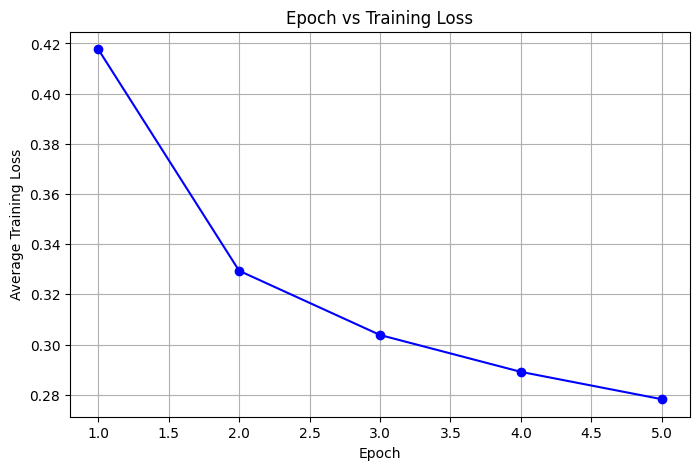

In [ ]:
#training loss
import matplotlib.pyplot as plt

epoch_train_losses=[0.4177,0.3294,0.3038,0.2891,0.2782]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_train_losses) + 1), epoch_train_losses, marker='o', color='b')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Epoch vs Training Loss')
plt.grid(True)
plt.show()